In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
from torch import optim
torch.cuda.is_available()

True

In [0]:
def data_preprocessing(prefix_path):
  X_test = np.array(np.load(prefix_path+"test_after_.npy"))
  y_test = np.load(prefix_path+"y_test.npy")
  person_train_valid = np.load(prefix_path+"person_train_valid.npy")
  X_train_valid = np.array(np.load(prefix_path+"train_after_.npy"))
  y_train_valid = np.load(prefix_path+"y_train_valid.npy")
  person_test = np.load(prefix_path+"person_test.npy")
  X_train_valid = X_train_valid[:,:22,:]
  X_test = X_test[:,:22,:]
  X_train_list=[]
  Y_train_list=[]
  X_test_list=[]
  Y_test_list=[]
  for i in range(9):
    idxs = np.argwhere(person_train_valid[:,0]==i).flatten()
    X_subject = X_train_valid[idxs]
    y_subject = y_train_valid[idxs]
    X_train_list.append(X_subject)
    Y_train_list.append(y_subject)
    idxs = np.argwhere(person_test[:,0]==i).flatten()
    X_subject_test = X_test[idxs]
    y_subject_test = y_test[idxs]
    X_test_list.append(X_subject_test)
    Y_test_list.append(y_subject_test)
  return X_train_valid, y_train_valid, X_test, y_test, X_train_list, Y_train_list,X_test_list,Y_test_list
  

In [0]:
prefix_path = "/content/drive/My Drive/239/project/"
X_train_valid, y_train_valid, X_test, y_test, X_train_list, Y_train_list,X_test_list,Y_test_list = data_preprocessing(prefix_path)

In [0]:
def train_valid_separate(X_train_valid, y_train_valid):
  dataset_size = X_train_valid.shape[0]
  indices = list(range(dataset_size))
  split = int(np.floor(0.2 * dataset_size))
  np.random.seed(42)
  np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]
  train_data = X_train_valid[train_indices]
  train_label = y_train_valid[train_indices]
  valid_data = X_train_valid[val_indices]
  valid_label = y_train_valid[val_indices]
  return train_data, train_label, valid_data, valid_label

In [0]:
train_data, train_label, valid_data, valid_label = train_valid_separate(X_train_valid, y_train_valid)

In [0]:
class LSTM(nn.Module):
  def __init__(self,seq_len,input_dim,hidden_dim,batch_size=16,dropout=0.1,bidirectional=False,output_dim=4):
    super(LSTM, self).__init__()
    self.seq_len = seq_len
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.batch_size = batch_size
    self.dropout_layer = nn.Dropout(p=dropout)
    self.bidirect = bidirectional
    self.num_direction = 2 if self.bidirect else 1
    self.lstm = nn.LSTM(self.input_dim,self.hidden_dim,bidirectional=self.bidirect)
    self.fc = nn.Linear(self.hidden_dim*self.num_direction,self.output_dim,bias=True)
    self.hidden_cell = self.update_hidden_cell()
  def update_hidden_cell(self):
    if use_cuda:
      h0 = Variable(torch.zeros((1*self.num_direction,self.batch_size,self.hidden_dim)).cuda())
      c0 = Variable(torch.zeros((1*self.num_direction,self.batch_size,self.hidden_dim)).cuda())
    else:
      h0 = Variable(torch.zeros((1*self.num_direction,self.batch_size,self.hidden_dim)))
      c0 = Variable(torch.zeros((1*self.num_direction,self.batch_size,self.hidden_dim)))
    return (h0,c0)
    
  def forward(self,input_data,batch_size):
    self.batch_size = batch_size
    self.hidden_cell = self.update_hidden_cell()
    if use_cuda:
      input_seq = Variable(input_data).cuda()
    else:
      input_seq = Variable(input_data)
    output,self.hidden_cell = self.lstm(input_seq,self.hidden_cell)
    last_output=output[-200:,:,:]
    output_with_dropout=self.dropout_layer(last_output)
    scores = self.fc(output_with_dropout)
    return scores

In [0]:
epoch_num = 150
batch_size = 32
dropout = 0.2
seq_length = 248
input_dim =22
hidden_dim = 100
lr = 0.0001
use_cuda = True
bidirectional=True
num_effective_output = 200
weight_decay = 0

In [0]:
if use_cuda:
  lstm_model = LSTM(seq_length,input_dim,hidden_dim,batch_size,dropout,bidirectional=True).cuda()
else: 
  lstm_model = LSTM(seq_length,input_dim,hidden_dim,batch_size,dropout,bidirectional=True)
loss_lstm = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(),lr=lr,weight_decay = weight_decay)

In [0]:
train_acc_list = []
valid_acc_list = []
train_num = train_data.shape[0]
train_per_epoch = train_num//batch_size
valid_num = valid_data.shape[0]
for e in range(epoch_num):
  print('Epoch ',e,'/',epoch_num)
  for j in range(train_per_epoch):
    chosen_idx = np.random.choice(np.arange(train_num),batch_size)
    X_batch = train_data[chosen_idx,:]
    y_batch = train_label[chosen_idx]
    optimizer.zero_grad()
    x_sample = np.transpose(X_batch,(2,0,1))
    x_sample = torch.tensor(x_sample).float()
    y_labels = np.tile(y_batch,num_effective_output)
    labels = Variable(torch.LongTensor(y_labels%769)).cuda()
#     label = torch.unsqueeze(label,0)
    score = lstm_model.forward(x_sample,batch_size)
    score = score.view(num_effective_output*batch_size,-1)
#     score = score.view(1,-1)
#     print(score.shape)
#     print(labels.shape)
    loss = loss_lstm(score,labels)
    loss.backward()
    optimizer.step()
  print('Current loss: ',loss.data.item())
  if e%5==4:
    ##Report validation accuracy after training
    valid_num = valid_data.shape[0]
    valid_batch = np.transpose(valid_data,(2,0,1))
    valid_tensor = torch.FloatTensor(valid_batch).cuda()
    y_predict = lstm_model.forward(valid_tensor,valid_num)
    y_predict = torch.mean(y_predict,0)
    _,y_pred_labels = torch.max(y_predict,1)
    y_predict = y_pred_labels.cpu().detach().numpy()
    correct = (y_predict == valid_label%769).sum()
    print('Validation accuracy is ',correct/valid_num)
    valid_acc_list.append(correct/valid_num)
    ##Report train accuracy after training
    train_total = np.transpose(train_data,(2,0,1))
    train_total_tensor = torch.FloatTensor(train_total).cuda()
    train_predict = lstm_model.forward(train_total_tensor,train_num)
    train_predict = torch.mean(train_predict,0)
    _,train_pred_labels = torch.max(train_predict,1)
    train_y_predict = train_pred_labels.cpu().detach().numpy()
    correct = (train_y_predict == train_label%769).sum()
    print('Train accuracy is ',correct/train_num)
    train_acc_list.append(correct/train_num)

Epoch  0 / 150
Current loss:  1.3770785331726074
Epoch  1 / 150
Current loss:  1.3939714431762695
Epoch  2 / 150
Current loss:  1.3960357904434204
Epoch  3 / 150
Current loss:  1.3759433031082153
Epoch  4 / 150
Current loss:  1.3853687047958374
Validation accuracy is  0.28841607565011823
Train accuracy is  0.26595744680851063
Epoch  5 / 150
Current loss:  1.3965659141540527
Epoch  6 / 150
Current loss:  1.3949484825134277
Epoch  7 / 150
Current loss:  1.3855235576629639
Epoch  8 / 150
Current loss:  1.3863742351531982
Epoch  9 / 150
Current loss:  1.3818333148956299
Validation accuracy is  0.3215130023640662
Train accuracy is  0.3173758865248227
Epoch  10 / 150
Current loss:  1.3805617094039917
Epoch  11 / 150
Current loss:  1.3781667947769165
Epoch  12 / 150
Current loss:  1.3777079582214355
Epoch  13 / 150
Current loss:  1.3723074197769165
Epoch  14 / 150
Current loss:  1.3760453462600708
Validation accuracy is  0.32860520094562645
Train accuracy is  0.3475177304964539
Epoch  15 / 15

In [0]:
##Report train accuracy after training
train_total = np.transpose(train_data,(2,0,1))
train_total_tensor = torch.FloatTensor(train_total).cuda()
train_predict = lstm_model.forward(train_total_tensor,train_num)
train_predict = torch.mean(train_predict,0)
_,train_pred_labels = torch.max(train_predict,1)
train_y_predict = train_pred_labels.cpu().detach().numpy()
correct = (train_y_predict == train_label%769).sum()
print('Train accuracy is ',correct/train_num)

Train accuracy is  0.6371158392434988


In [0]:
valid_num = valid_data.shape[0]
valid_batch = np.transpose(valid_data,(2,0,1))
valid_tensor = torch.FloatTensor(valid_batch).cuda()
y_predict = lstm_model.forward(valid_tensor,valid_num)
y_predict = torch.mean(y_predict,0)
_,y_pred_labels = torch.max(y_predict,1)
y_predict = y_pred_labels.cpu().detach().numpy()
correct = (y_predict == valid_label%769).sum()
print('Validation accuracy is ',correct/valid_num)

Validation accuracy is  0.3947990543735225


In [0]:
test_num = X_test.shape[0]
test_batch = np.transpose(X_test,(2,0,1))
test_tensor = torch.FloatTensor(test_batch).cuda()
y_predict = lstm_model.forward(test_tensor,test_num)
y_predict = torch.mean(y_predict,0)
_,y_pred_labels = torch.max(y_predict,1)
y_predict = y_pred_labels.cpu().detach().numpy()
correct = (y_predict == y_test%769).sum()
print('Test accuracy is ',correct/test_num)

Test accuracy is  0.39954853273137697


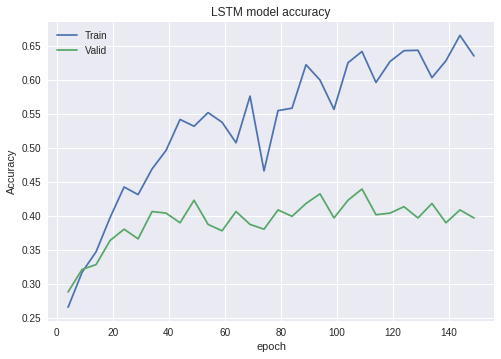

In [0]:
from matplotlib import pyplot as plt
t = [5*i+4 for i in range(30)]
plt.plot(t,train_acc_list)
plt.plot(t,valid_acc_list)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('LSTM model accuracy')
plt.gca().legend(('Train','Valid'))